# Feature extraction, continued

This notebook begins with Friday morning, carrying on with the fan-fiction case study we began on Thursday afternoon.

Assuming we’re starting with a new R session, the code below will fast-forward to where we left off.

In [1]:
# attach necessary packages
library(tidyverse)
library(tidytext)
library(rvest)
library(polite)

# connect to ao3 and download annacharlier's story
session <- bow('https://www.archiveofourown.org/works/24280306')
html_doc <- session %>% scrape()

# extract the text of the story
text <- html_doc %>%
    html_element('div#chapters div.userstuff') %>%
    html_text2()

# create a one-row tibble
fan_fics <- tibble(
    ao3_id = 24280306,
    text = text
)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘rvest’


The following object is masked from ‘package:readr’:

    guess_encoding




### Character-based features

You can also split your text into character-based n-grams, (sometimes called "shingles" because they overlap like roof tiles). Character n-grams were proposed early in the 21st century as a "language agnositic" featureset, so that, for example, you could treat Modern Greek and Mandarin with the same algorithm as Latin-based languages.

Meanwhile, character n-grams have also been useful in the study of poetry, where sound may have as significant a role to play as meaning in structuring the text. 

Character n-grams can have the effect of capturing abstract morphological as well as semantic units. In English, the 4-gram "walk" matches "walk", "walks", and "walked", while the ngrams "ing", and "ly", match abstract part-of-speech categories like *participle*, *adverb*. Note, again, that these different kinds of information are combined in the same channel—sound frequency—while a formal parser would separate them into different columns.

Here we use `unnest_tokens()` to tokenize Annacharlier’s story into character 3-grams.

In [2]:
shingles <- fan_fics %>%
    unnest_tokens(output=ngram, input=text, token="character_shingles", n=3)

In [3]:
head(shingles)

ao3_id,ngram
<dbl>,<chr>
24280306,the
24280306,hey
24280306,eys
24280306,yst
24280306,sta
24280306,tay


In [4]:
shingles %>%
    count(ngram, sort=TRUE) %>%
    head(10)

ngram,n
<chr>,<int>
the,356
her,311
she,299
ing,229
tra,194
and,175
atr,171
cat,170
ora,152


## Parsing and annotating with language-specific models

To extract more precise information about text, it helps to have a pre-trained, language-specific **model**. There are several **natural language processing** [packages available for R](https://cran.r-project.org/web/views/NaturalLanguageProcessing.html); to be honest, I’m not an expert in any of them. We can cover the basics here, but if you want to do NLP, you’ll need to work through a more specialized tutorial and figure out which tools best suit your research.

Something that’s going to be true no matter which tools you use: their accuracy will depend upon the model, which in turn depends upon the training material. Results for English tend to be better than for other languages, because the models have been trained on more data. Likewise, results for newspaper articles, financial reports, and office emails will be better than for Early Modern novels, because the language of the training material is often newspapers and business documents.

In addition to the annotation software, you will also have to download a model for the language you’re working with (or train your own—a task well beyond the scope of this workshop, but potentially rewarding if you happen to have an interesting corpus that’s already been annotated by hand). Often this is a bulky binary file that the NLP package will want to store somewhere on your computer—make sure you remember where it is, because you’ll need to load it each time you use the program. You might have a collection of models for different langauges.

### Simple annotating with udpipe

For this workshop, we’re going to do some simple parsing with **udpipe**, a package that I find relatively easy to get started with. It doesn’t produce tibbles by default, but it fits into tidyverse workflows with relatively little friction.

First, we have to install the package:

In [5]:
# only need to do this once
install.packages('udpipe')


The downloaded binary packages are in
	/var/folders/_k/nhmmjzg96r318bm9jvyvv7ph0000gn/T//Rtmp2ABfmJ/downloaded_packages


In [6]:
library(udpipe)

We also need to download the language model(s) we’re interested in. For this exercise, I’m using 'english'. If someone wants to test out the 'german-hdt' model later, let me know how it seems to perform for you.

In [7]:
udpipe_download_model('english')


 - This model has been trained on version 2.5 of data from https://universaldependencies.org

 - The model is distributed under the CC-BY-SA-NC license: https://creativecommons.org/licenses/by-nc-sa/4.0

 - Visit https://github.com/jwijffels/udpipe.models.ud.2.5 for model license details.

 - For a list of all models and their licenses (most models you can download with this package have either a CC-BY-SA or a CC-BY-SA-NC license) read the documentation at ?udpipe_download_model. For building your own models: visit the documentation by typing vignette('udpipe-train', package = 'udpipe')




language,file_model,url,download_failed,download_message
<chr>,<chr>,<chr>,<lgl>,<chr>
english-ewt,/Users/chris/Documents/git/rostock_r/english-ewt-ud-2.5-191206.udpipe,https://raw.githubusercontent.com/jwijffels/udpipe.models.ud.2.5/master/inst/udpipe-ud-2.5-191206/english-ewt-ud-2.5-191206.udpipe,FALSE,OK


The output from this download command contains the location where the model has been stored on your computer. On my computer, it’s in the project folder for this workshop. For this session, I’m just going to leave it there, but if I wanted to use it in several different projects, it might make sense to store it somewhere central.

Wherever I keep the model file, I need to be able to pass a path to it when I instantiate a model object in R:

In [8]:
model_en <- udpipe_load_model('english-ewt-ud-2.5-191206.udpipe')

The model needs to be loaded once per session. Then whenever I want to annotate some text, I have to pass it to the annotation function, `udpipe_annotate()`, along with the text itself. I’m going pass the whole story as a string (I’m pretty sure I still have it stored in the variable `text`).

By default `udpipe_annotate()` returns a list, but it can be converted to a tibble with `as_tibble()`.

In [9]:
tokens <- udpipe_annotate(model_en, text) %>%
    as_tibble()

In [10]:
print(tokens)

# A tibble: 6,890 × 14
   doc_id paragraph_id sentence_id sentence     token_id token lemma upos  xpos 
   <chr>         <int>       <int> <chr>        <chr>    <chr> <chr> <chr> <chr>
 1 doc1              1           1 They stay t… 1        They  they  PRON  PRP  
 2 doc1              1           1 They stay t… 2        stay  stay  VERB  VBP  
 3 doc1              1           1 They stay t… 3        that  that  DET   DT   
 4 doc1              1           1 They stay t… 4        way   way   NOUN  NN   
 5 doc1              1           1 They stay t… 5        for   for   ADP   IN   
 6 doc1              1           1 They stay t… 6        a     a     DET   DT   
 7 doc1              1           1 They stay t… 7        long  long  ADJ   JJ   
 8 doc1              1           1 They stay t… 8        time  time  NOUN  NN   
 9 doc1              1           1 They stay t… 9        ,     ,     PUNCT ,    
10 doc1              1           1 They stay t… 10       Catra Catra PROPN NNP  
# … w

Each row in the tibble is a single token. We get ids for the document, paragraph, sentence, and token. We get the token itself, plus a lemmatized (stemmed) version. We get part-of-speech tags according to two different classification systems, and additional features for some parts of speech: e.g. mood, number. We also get information about the structure of the sentence according to dependency grammar.

By default, we also get, for every single token, a full copy of the sentence to which it belongs. I’m going to save that information in a separate tibble and then remove it.

In [11]:
sentences <- tokens %>%
    group_by(sentence_id) %>%
    summarize(sentence=first(sentence))

In [12]:
head(sentences)

sentence_id,sentence
<int>,<chr>
1,"They stay that way for a long time, Catra’s face tucked into Adora’s shoulder, Adora gently cradling Catra’s head."
2,"Adora is careful not to hug Catra too hard or make her feel restrained, anticipating the moment that Catra will start to pull away — but Catra doesn’t."
3,"She hangs on so tightly it hurts, her claws digging through Adora’s jacket and into her back, latching into her like she did when she was a kitten and didn’t know how much her claws could hurt."
4,"Adora tries not to wince, tries not to move a single muscle, worried that if she does the spell will break and Catra will struggle away, appalled at having shown weakness."
5,But Catra doesn’t let go.
6,And so neither does Adora.


Ok, we have one copy of each sentence now, associated with its sentence id. We can refer to this later if we want to figure out where something is in the story. We no longer need the `sentence` column in `tokens`.

In [13]:
tokens <- tokens %>% select(-sentence)

In [14]:
head(tokens)

doc_id,paragraph_id,sentence_id,token_id,token,lemma,upos,xpos,feats,head_token_id,dep_rel,deps,misc
<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
doc1,1,1,1,They,they,PRON,PRP,Case=Nom|Number=Plur|Person=3|PronType=Prs,2,nsubj,NA,NA
doc1,1,1,2,stay,stay,VERB,VBP,Mood=Ind|Tense=Pres|VerbForm=Fin,0,root,NA,NA
doc1,1,1,3,that,that,DET,DT,Number=Sing|PronType=Dem,4,det,NA,NA
doc1,1,1,4,way,way,NOUN,NN,Number=Sing,2,obj,NA,NA
doc1,1,1,5,for,for,ADP,IN,NA,8,case,NA,NA
doc1,1,1,6,a,a,DET,DT,Definite=Ind|PronType=Art,8,det,NA,NA


One simple form of analysis is to `filter()` the tibble according to part of speech information. Column `upos` contains tags from the [Universal POS tagset](https://universaldependencies.org/u/pos/index.html). Column `xpos` theoretically contains language-specific tags if they’re available. For now, let’s use `upos` to select adjectives and produce a count of the most common:

In [15]:
tokens %>%
    filter(upos=='ADJ') %>%
    count(token, sort=TRUE) %>%
    head(10)

token,n
<chr>,<int>
long,10
good,9
small,8
okay,7
little,6
only,6
first,5
last,5
more,5


Here’s a slightly more complicated example. I’m going to see which sentence contain the most imperative verbs.

I’ve noticed that the `feats` column includes information about the mood of finite verbs. Although there aren’t any examples in the rows that we’ve looked at so far, I bet that imperatives have the string `Mood=Imp` in this column. To test for that, I can use `str_detect()` with a `filter()`.

In [16]:
tokens %>%
    filter(str_detect(feats, 'Mood=Imp')) %>%
    head(10)

doc_id,paragraph_id,sentence_id,token_id,token,lemma,upos,xpos,feats,head_token_id,dep_rel,deps,misc
<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
doc1,6,15,1,Bow,Bow,VERB,VB,Mood=Imp|VerbForm=Fin,0,root,NA,NA
doc1,18,65,2,Get,get,VERB,VB,Mood=Imp|VerbForm=Fin,0,root,NA,NA
doc1,18,66,3,leave,leave,VERB,VB,Mood=Imp|VerbForm=Fin,0,root,NA,NA
doc1,22,77,12,let,let,VERB,VB,Mood=Imp|VerbForm=Fin,8,parataxis,NA,NA
doc1,25,87,1,Stop,stop,VERB,VB,Mood=Imp|VerbForm=Fin,0,root,NA,SpaceAfter=No
doc1,33,121,4,stop,stop,VERB,VB,Mood=Imp|VerbForm=Fin,0,root,NA,SpaceAfter=No
doc1,33,122,1,Stop,stop,VERB,VB,Mood=Imp|VerbForm=Fin,0,root,NA,NA
doc1,33,125,2,Let,let,VERB,VB,Mood=Imp|VerbForm=Fin,0,root,NA,NA
doc1,33,125,3,go,go,VERB,VB,Mood=Imp|VerbForm=Fin,2,xcomp,NA,SpaceAfter=No


Aha! I was right! Now, what remains is to `group_by()` sentence and count the results. But I think I’d also like to retain a list of the matching verbs in each case. For that, I can do a custom `summarise()` instead of the usual `count()`. In addition to using the aggregation function `n()` to count the results, I can use `str_c()` to actually paste together the tokens themselves.

Even though some sentences might have more than one row in the `tokens` table, `str_c()` can create a single string with all the tokens concatenated together. See `help(str_c)` for more details on how the optional parameter `collapse` works.

In [17]:
tokens %>%
    filter(str_detect(feats, 'Mood=Imp')) %>%
    group_by(sentence_id) %>%
    summarise(n=n(), tokens=str_c(token, collapse=', ')) %>%
    arrange(desc(n))

sentence_id,n,tokens
<int>,<int>,<chr>
125,2,"Let, go"
352,2,"go, get"
424,2,"Do, be"
15,1,Bow
65,1,Get
66,1,leave
77,1,let
87,1,Stop
121,1,stop


### Collocations

We can use udpipe to search for word collocations, somewhat as we did with tidytext. But udpipe offers us the ability to sort collocations not based on raw frequency, but on how "interesting" the pairing is from an information-theoretical perspective. The function `keywords_collocation()` calculates counts for both the left and the right member of each ngram independently, and then scores the ngram according to how unlikely it is that the occurrences are independent of each other. This has the effect of surfacing ngrams whose members are closely related to each other as opposed to those simply made up of very common words.

`keywords_collocation()` takes as input a table of tokens like that produced by `udpipe_annotate`. The mandatory parameter `term` tells it which column contains the words (you might choose either `token` or `lemma`, depending on whether you want e.g. 'walk' and 'walks' folded together). A second mandatory parameter, `group` indicates which column will define the scope within which collocations can occur (choose `sentence_id` to only see pairings within the same sentence, or `paragraph_id` to allow collocations across sentence boundaries). Note that because this function doesn’t play by all the tidyverse rules, we have to put quotation marks around these column names.

For more details, see `help(keywords_collocation)`.

Because udpipe, unlike tidytext, treats punctuation marks as tokens, I’m going to filter them out before checking collocations.

In [18]:
tokens %>%
    filter(upos != 'PUNCT') %>%
    keywords_collocation(term='lemma', group='sentence_id') %>%
    head(10)

,keyword,ngram,left,right,freq,freq_left,freq_right,pmi,md,lfmd
,<chr>,<dbl>,<chr>,<chr>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>
1,fall asleep,2,fall,asleep,4,6,5,9.571626,-0.9068906,-11.38541
2,through space,2,through,space,3,9,5,8.571626,-2.3219281,-13.21548
3,Horde Prime,2,Horde,Prime,6,8,16,8.063479,-1.8300750,-11.72363
4,right now,2,right,now,3,9,9,7.723629,-3.1699250,-14.06348
5,know how,2,know,how,5,17,8,7.712982,-2.4436067,-12.60020
6,how ’d,2,how,’d,4,17,8,7.391054,-3.0874628,-13.56598
7,at last,2,at,last,3,32,5,6.741551,-4.1520031,-15.04556
8,long time,2,long,time,5,15,18,6.723629,-3.4329594,-13.58955
9,long moment,2,long,moment,3,15,11,6.697157,-4.1963972,-15.08995


The resulting table gives the count of the ngram, as well individual counts of the left and right members; the final three columns are alternative measures of how unlikely the words are to have cooccurred by chance. By default the table is sorted by `pmi`, or **pointwise mutual information**. For details, see `help(keywords_collocation)`.

## Sentiment

The final feature that we’re going to look at in this section is **sentiment**. So-called "affective computing" is a popular subject in commercial as well as academic research within digital humanities: the ability to accurately parse customer feedback, shareholder confidence, political feelings, etc., is of course potentially highly profitable, and we may expect machine learning in particular to make great advances in this domain in the coming years.

For now, however, much sentiment analysis still depends on relatively simple dictionary approaches, in which a fixed lexicon has been hand-tagged with scores or with fixed categories. Several such dictionaries are available through tidytext.

The function `get_sentiments()` can be used to retrieve four such dictionaries. The choices are "afinn", "bing", "nrc", or "loughran". Here are few quick examples of each.

### Binary classifier

The "bing" lexicon simply classifies each word as "positive" or "negative". How many words does it have?

In [19]:
sent_bing <- get_sentiments('bing')
str(sent_bing)

tibble [6,786 × 2] (S3: tbl_df/tbl/data.frame)
 $ word     : chr [1:6786] "2-faces" "abnormal" "abolish" "abominable" ...
 $ sentiment: chr [1:6786] "negative" "negative" "negative" "negative" ...


What are some examples of "positive" words?

In [20]:
sent_bing %>%
    filter(sentiment=='positive') %>%
    head(10)

word,sentiment
<chr>,<chr>
abound,positive
abounds,positive
abundance,positive
abundant,positive
accessable,positive
accessible,positive
acclaim,positive
acclaimed,positive
acclamation,positive


And "negative" words?

In [21]:
sent_bing %>%
    filter(sentiment=='negative') %>%
    head(10)

word,sentiment
<chr>,<chr>
2-faces,negative
abnormal,negative
abolish,negative
abominable,negative
abominably,negative
abominate,negative
abomination,negative
abort,negative
aborted,negative


### Adding sentiment data to `tokens`

Let’s try adding the sentiment tags to our `tokens` table. We can use a join operation to match each word in `tokens` against the sentiment dictionary. 

- Not all the words will exist in the dictionary: a `left_join()` will preserve all rows in `tokens` and just match those that it can; `NA`s will be introduced for words it can’t find.

We need a column to join on: I’ll create column `word` in `tokens` that’s lowercased just like the `word` column in the dictionaries.

In [22]:
tokens_bing <- tokens %>% 
    mutate(word = str_to_lower(token)) %>%
    left_join(sent_bing)

Joining, by = "word"


In [23]:
tokens_bing %>%
    filter(! is.na(sentiment)) %>%
    head()

doc_id,paragraph_id,sentence_id,token_id,token,lemma,upos,xpos,feats,head_token_id,dep_rel,deps,misc,word,sentiment
<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
doc1,1,2,6,hug,hug,VERB,VB,VerbForm=Inf,3,conj,NA,NA,hug,positive
doc1,1,2,9,hard,hard,ADV,RB,Degree=Pos,6,advmod,NA,NA,hard,negative
doc1,1,3,2,hangs,hang,VERB,VBZ,Mood=Ind|Number=Sing|Person=3|Tense=Pres|VerbForm=Fin,0,root,NA,NA,hangs,negative
doc1,1,3,7,hurts,hurt,VERB,VBZ,Mood=Ind|Number=Sing|Person=3|Tense=Pres|VerbForm=Fin,2,ccomp,NA,SpaceAfter=No,hurts,negative
doc1,1,3,24,like,like,SCONJ,IN,NA,26,mark,NA,NA,like,positive
doc1,1,3,41,hurt,hurt,VERB,VB,VerbForm=Inf,35,ccomp,NA,SpaceAfter=No,hurt,negative


### Working with sentiment tags

We can use the sentiment tags to filter the token data, for example to create counts of the most frequent "positive" and "negative" words.

In [24]:
tokens_bing %>%
    filter(sentiment == 'positive') %>%
    count(word, sort=TRUE) %>%
    head(10)

word,n
<chr>,<int>
like,24
glimmer,12
good,9
right,9
bright,5
enough,5
better,4
clearly,4
safe,4


In [25]:
tokens_bing %>%
    filter(sentiment == 'negative') %>%
    count(word, sort=TRUE) %>%
    head(10)

word,n
<chr>,<int>
horde,8
hurt,8
pain,5
sorry,5
stupid,5
cold,4
falls,4
hard,4
rage,4


After consulting the cheat sheets, we can visualize these top words with ggplot2:

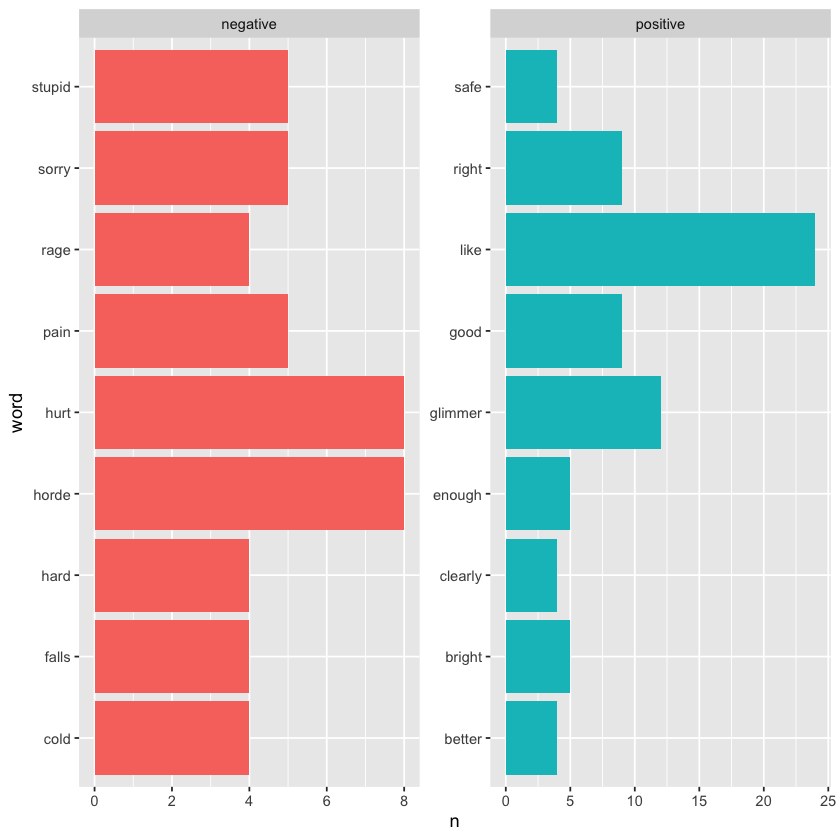

In [26]:
tokens_bing %>%
    filter(! is.na(sentiment)) %>%
    group_by(sentiment) %>%
    count(word, sort=TRUE) %>%
    filter(row_number()<10) %>%

ggplot() +
    aes(n, word, fill=sentiment) +
    geom_col(show.legend = FALSE) +
    facet_wrap(~sentiment, scales="free")

### Multi-category tags

The "nrc" lexicon includes, in addition to "positive" and "negative", eight named sentiment tags:

 - "anger"
 - "anticipation"
 - "disgust"
 - "fear"
 - "joy"
 - "sadness"
 - "surprise"
 - "trust"

In [27]:
sent_nrc <- get_sentiments('nrc')
print(sent_nrc)

# A tibble: 13,872 × 2
   word        sentiment
   <chr>       <chr>    
 1 abacus      trust    
 2 abandon     fear     
 3 abandon     negative 
 4 abandon     sadness  
 5 abandoned   anger    
 6 abandoned   fear     
 7 abandoned   negative 
 8 abandoned   sadness  
 9 abandonment anger    
10 abandonment fear     
# … with 13,862 more rows


Some words are tagged with more than one sentiment, so the number of rows is greater than the number of words in the lexicon. How many unique words does this lexicon have? About the same as "bing", it turns out.

In [28]:
sent_nrc %>% summarise(n_distinct(word))

n_distinct(word)
<int>
6453


#### Joining against words with multiple tags

We’ll add the tags to our token table with `left_join()` as we did above. But this time, a row in `tokens` may match against multiple rows in `sent_nrc` if one word has multiple tags in the dictionary (e.g. 'abandon' above). When that happens, we'll get multiple row for the same token in our result, and the tokens table will be longer than when we started.

In [29]:
tokens_nrc <- tokens %>% 
    mutate(word = str_to_lower(token)) %>%
    left_join(sent_nrc)

Joining, by = "word"


Let’s see the results—we’ll filter to find only those rows with sentiment data.

In [30]:
tokens_nrc %>%
    filter(! is.na(sentiment)) %>%
    select(sentence_id, token_id, token, upos, sentiment) %>%
    head(20)

sentence_id,token_id,token,upos,sentiment
<int>,<chr>,<chr>,<chr>,<chr>
1,7,long,ADJ,anticipation
1,8,time,NOUN,anticipation
1,17,shoulder,NOUN,positive
1,17,shoulder,NOUN,trust
2,3,careful,ADJ,positive
2,6,hug,VERB,joy
2,6,hug,VERB,positive
2,6,hug,VERB,trust
2,14,restrained,ADJ,fear


Now we’ll tally each sentiment by sentence:

In [31]:
sentiment_tally <- tokens_nrc %>%
    filter(! is.na(sentiment)) %>%
    count(sentence_id, sentiment)

In [32]:
sentiment_tally %>% head(10)

sentence_id,sentiment,n
<int>,<chr>,<int>
1,anticipation,2
1,positive,1
1,trust,1
2,anticipation,1
2,fear,1
2,joy,1
2,positive,3
2,trust,1
3,anger,1


I’m going to plot the tallies by sentence number, so we can visualize how sentiments are distributed along the narrative. But "negative" and "positive" seem a little different from the other categories, so I’ll plot them separately.

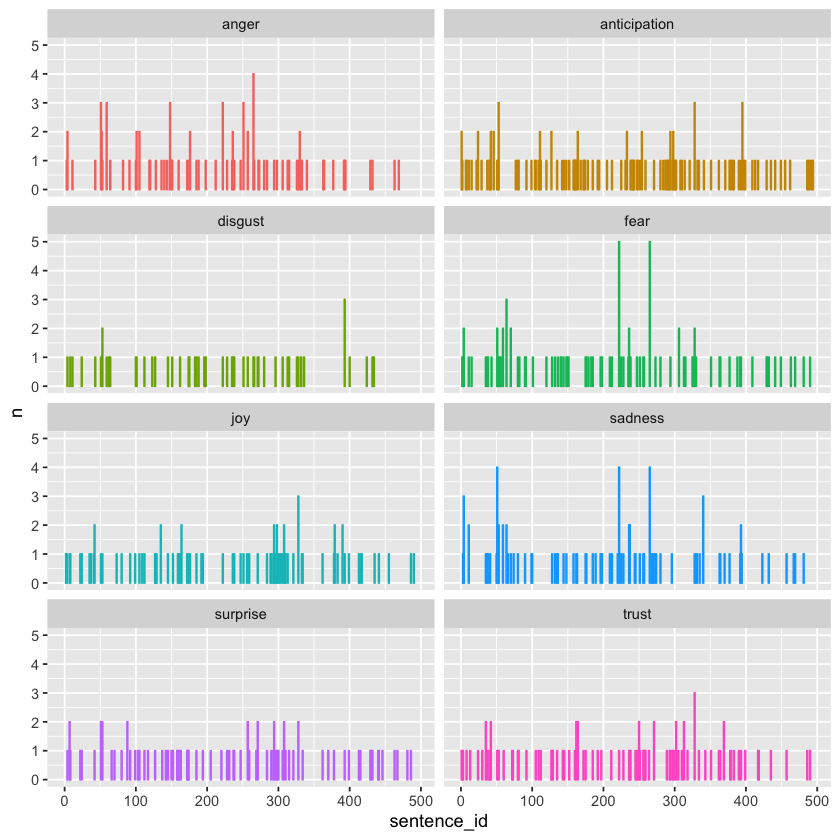

In [33]:
sentiment_tally %>%
    filter(! sentiment %in% c('positive', 'negative')) %>%

ggplot() +
    aes(x=sentence_id, y=n, col=sentiment) +
    geom_col(show.legend = FALSE) +
    facet_wrap(~sentiment, ncol=2)

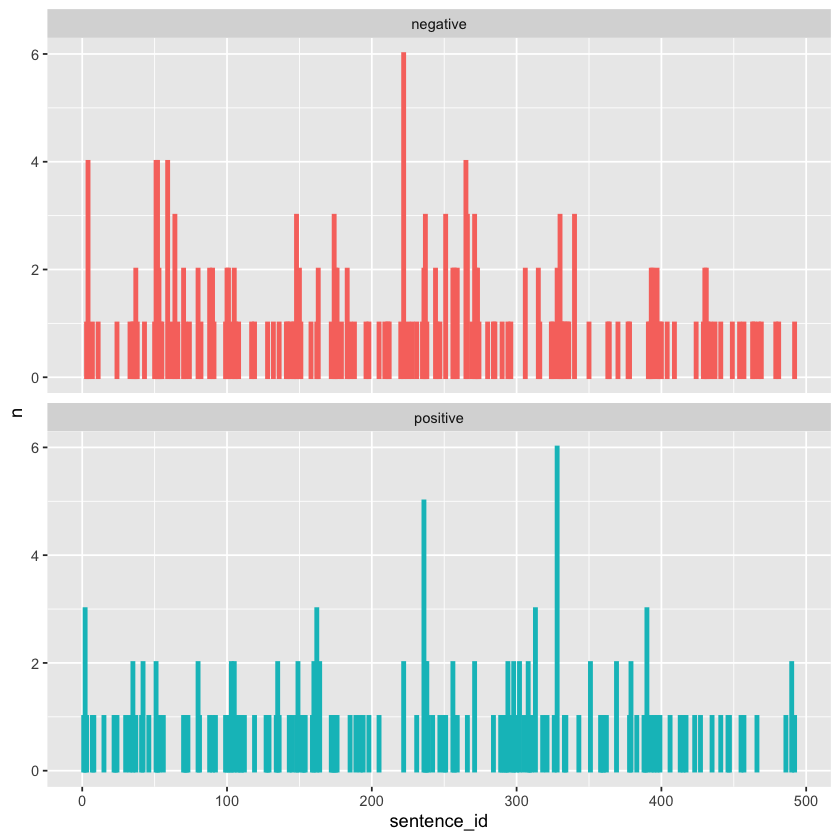

In [34]:
sentiment_tally %>%
    filter(sentiment %in% c('positive', 'negative')) %>%

ggplot() +
    aes(x=sentence_id, y=n, col=sentiment) +
    geom_col(show.legend = FALSE, size=1) +
    facet_wrap(~sentiment, ncol=1)

### Numeric sentiment values

The "afinn" lexicon gives each word a score between +5 and -5:

In [35]:
sent_afinn <- get_sentiments('afinn')
print(sent_afinn)

# A tibble: 2,477 × 2
   word       value
   <chr>      <dbl>
 1 abandon       -2
 2 abandoned     -2
 3 abandons      -2
 4 abducted      -2
 5 abduction     -2
 6 abductions    -2
 7 abhor         -3
 8 abhorred      -3
 9 abhorrent     -3
10 abhors        -3
# … with 2,467 more rows


What are the most "positive" words?

In [36]:
sent_afinn %>% 
    arrange(desc(value)) %>%
    head(10)

word,value
<chr>,<dbl>
breathtaking,5
hurrah,5
outstanding,5
superb,5
thrilled,5
amazing,4
awesome,4
brilliant,4
ecstatic,4


Let’s add the afinn sentiment values to our token data:

In [37]:
tokens_afinn <- tokens %>%
    mutate(word = str_to_lower(token)) %>%
    left_join(sent_afinn) %>%
    rename(sentiment=value)

Joining, by = "word"


In [38]:
tokens_afinn %>% 
    filter(! is.na(sentiment)) %>%
    head(10)

doc_id,paragraph_id,sentence_id,token_id,token,lemma,upos,xpos,feats,head_token_id,dep_rel,deps,misc,word,sentiment
<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
doc1,1,2,3,careful,careful,ADJ,JJ,Degree=Pos,0,root,NA,NA,careful,2
doc1,1,2,6,hug,hug,VERB,VB,VerbForm=Inf,3,conj,NA,NA,hug,2
doc1,1,2,9,hard,hard,ADV,RB,Degree=Pos,6,advmod,NA,NA,hard,-1
doc1,1,3,7,hurts,hurt,VERB,VBZ,Mood=Ind|Number=Sing|Person=3|Tense=Pres|VerbForm=Fin,2,ccomp,NA,SpaceAfter=No,hurts,-2
doc1,1,3,24,like,like,SCONJ,IN,NA,26,mark,NA,NA,like,2
doc1,1,3,41,hurt,hurt,VERB,VB,VerbForm=Inf,35,ccomp,NA,SpaceAfter=No,hurt,-2
doc1,1,4,15,worried,worried,ADJ,JJ,Degree=Pos,7,advcl,NA,NA,worried,-3
doc1,1,4,27,struggle,struggle,VERB,VB,VerbForm=Inf,23,conj,NA,NA,struggle,-2
doc1,1,4,30,appalled,appal,ADJ,JJ,Degree=Pos,15,ccomp,NA,NA,appalled,-2


### Aggregating numeric sentiment values

For a given unit of text, we’ll potentially have both positive and negative words. We have the option of adding them to get an overall "average" sentiment for the passage. This is something we can’t do with categorical data. Let’s calculate this metric for each sentence of *Don’t Go*.

In [39]:
afinn_sum <- tokens_afinn %>%
    filter(! is.na(sentiment)) %>%
    group_by(sentence_id) %>%
    summarise(sentiment=sum(sentiment))

In [40]:
afinn_sum %>% head(10)

sentence_id,sentiment
<int>,<dbl>
2,3
3,-2
4,-9
9,1
10,1
11,2
12,2
15,-2
19,0


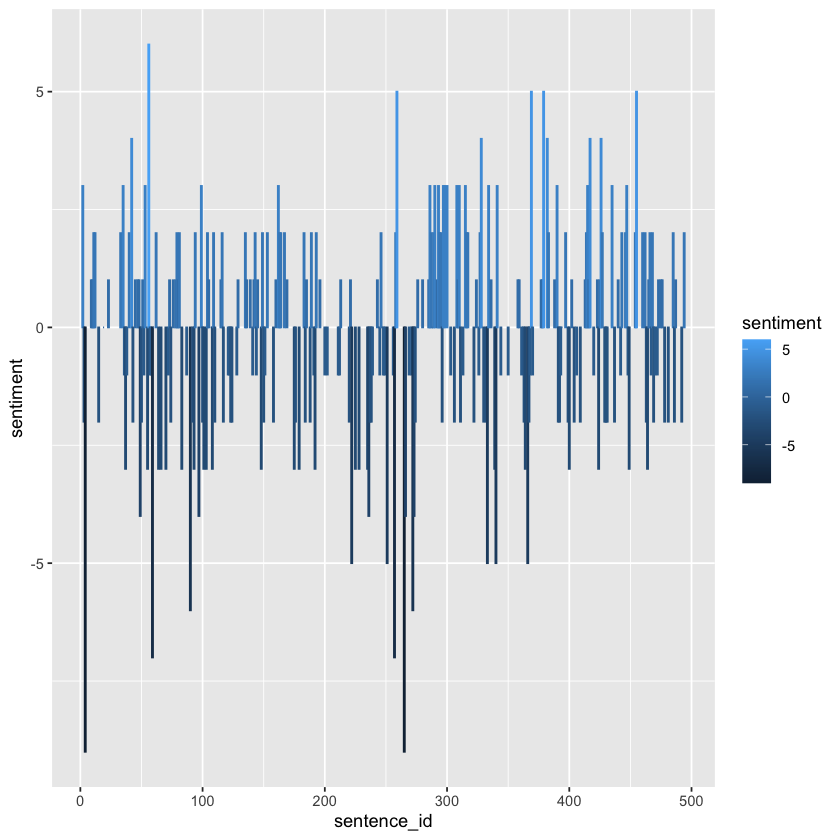

In [41]:
ggplot(afinn_sum) +
    aes(x=sentence_id, y=sentiment, col=sentiment) +
    geom_col()